# Data

## Libraries for Data Processing

In [1]:
%matplotlib inline

String processing and utility libraries

In [2]:
import os
import glob
import string
import re
import imageio

Libraries for functional programming

In [3]:
import operator as op
import itertools as it
from functools import reduce, partial
import toolz as tz
import toolz.curried as c

Libraries for numerical programming

In [4]:
import numpy as np
import pandas as pd
from scipy import (stats, sparse, linalg, 
                   spatial, integrate, optimize, io)

Libraries for plotting and visualization

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

## Working with unstructured text data

### Categorical and one-hot encoding

See examples from S05_Text notebook.

### Term frequency - inverse document frequency (tf-idf)

> In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Nowadays, tf-idf is one of the most popular term-weighting schemes; 83% of text-based recommender systems in the domain of digital libraries use tf-idf.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Tf–idf)

#### Documents 

In [6]:
paths = glob.glob(os.path.join('data', 'Gutenberg', '*.txt') )
names = [os.path.splitext(os.path.split(path)[-1])[0] for path in paths]
names

['blake-poems',
 'carroll-alice',
 'shakespeare-caesar',
 'whitman-leaves',
 'milton-paradise',
 'bible-kjv',
 'austen-persuasion',
 'melville-moby_dick',
 'edgeworth-parents',
 'chesterton-thursday',
 'burgess-busterbrown',
 'chesterton-ball',
 'austen-emma',
 'chesterton-brown',
 'shakespeare-hamlet',
 'austen-sense',
 'shakespeare-macbeth',
 'bryant-stories']

In [7]:
N = len(names)

#### Simple processing to find words in each document

Standard Python idiom.

In [8]:
doc_terms = []
for path in paths:
    with open(path, encoding='latin-1') as f:
        text = f.read()
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        words = text.split()
        doc_terms.append(words)

Using a functional idiom

In [9]:
doc_terms = tz.pipe(
    paths,
    c.map(partial(open, encoding='latin-1')),
    c.map(lambda x: x.read()),
    c.map(lambda x: x.lower()),
    c.map(lambda x: x.translate(str.maketrans('', '', string.punctuation))),
    c.map(lambda x: x.split()),
    list
)

#### Term frequency

This is just a word count for each document.

In [10]:
tf = {name: tz.frequencies(doc) 
      for name, doc in zip(names, doc_terms)}

#### Document frequency

This is how many documents a term appears in.

In [11]:
df = tz.frequencies(tz.concat(d.keys() for d in tf.values()))

#### Inverse document frequency 

This weights each term by the inverse frequency of its appearance across different documents, and reduces the important of common words like "the".

In [12]:
idf = {term: np.log((1 + N)/(1 + count)) for term, count in df.items()}

#### Term frequency - inverse document frequency

This is just the product of tf and idf, and a measure of the importance of each term in a document.

In [13]:
terms = list(tz.unique(tz.concat(doc_terms)))

In [14]:
tf_idf = {}
for name, doc in tf.items():
    d = {}
    for term in terms:
        d[term] = doc.get(term, 0) * idf[term]
    tf_idf[name] = d

#### Convert to a structured data type

In [15]:
tf_idf = pd.DataFrame(tf_idf)

In [16]:
tf_idf.iloc[:5, :5]

,austen-emma,austen-persuasion,austen-sense,bible-kjv,blake-poems
00,0.0,0.0,0.0,0.0,0.0
00021053,0.0,0.0,0.0,0.0,0.0
00081429,0.0,0.0,0.0,0.0,0.0
00482129,0.0,0.0,0.0,0.0,0.0
01,0.0,0.0,0.0,0.0,0.0


#### Distinctive words in each document

These are words that appear frequently in that document but not in others.

In [17]:
pd.DataFrame({doc: series.sort_values(ascending=False).index[:5] 
              for doc, series in tf_idf.items()}).T

,0,1,2,3,4
austen-emma,emma,harriet,weston,knightley,elton
austen-persuasion,elliot,anne,wentworth,musgrove,russell
austen-sense,elinor,marianne,dashwood,jennings,mrs
bible-kjv,unto,israel,saith,thee,thou
blake-poems,thel,weep,thee,lyca,vales
bryant-stories,jackal,margery,brahmin,nightingale,epaminondas
burgess-busterbrown,buster,browns,joe,blacky,billy
carroll-alice,alice,gryphon,dormouse,duchess,hatter
chesterton-ball,turnbull,macian,evan,turnbulls,have
chesterton-brown,flambeau,boulnois,muscari,brown,fanshaw


#### Why is "macb" the top hit for Macbeth? 

In [18]:
tf['shakespeare-macbeth']['macb']

137

In [19]:
text = open('data/gutenberg/shakespeare-macbeth.txt', encoding='latin-1').read()
re.findall('macb[^e].*\n', text, re.IGNORECASE)[:10]

['Macb. So foule and faire a day I haue not seene\n',
 'Macb. Stay you imperfect Speakers, tell me more:\n',
 "Macb. Into the Ayre: and what seem'd corporall,\n",
 'Macb. Your Children shall be Kings\n',
 'Macb. And Thane of Cawdor too: went it not so?\n',
 'Macb. The Thane of Cawdor liues:\n',
 'Macb. Glamys, and Thane of Cawdor:\n',
 'Macb. Two Truths are told,\n',
 'Macb. If Chance will haue me King,\n',
 'Macb. Come what come may,\n']

### Image data

In [20]:
paths = glob.glob(os.path.join('data', 'POKEMON', '*.png') )[:3]

imgs = np.array([imageio.imread(path) for path in paths])

In [21]:
imgs.shape

(3, 215, 215, 4)

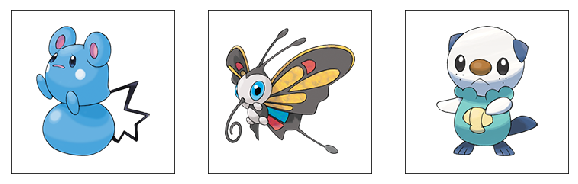

In [22]:
fig, axes = plt.subplots(1,3,figsize=(10,3))
for ax, img in zip(axes, imgs):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

## Using `pandas` for data munging

In [23]:
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv"

In [24]:
tips = pd.read_csv(url)

### Inspecting a data frame

In [25]:
tips.shape

(244, 7)

In [26]:
tips.dtypes

total_bill    float64
tip           float64
sex            object
smoker         object
day            object
time           object
size            int64
dtype: object

In [27]:
tips.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

In [28]:
tips.index

RangeIndex(start=0, stop=244, step=1)

In [29]:
tips.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


In [30]:
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


In [31]:
tips.tail(3)

,total_bill,tip,sex,smoker,day,time,size
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


In [32]:
tips.sample(3)

,total_bill,tip,sex,smoker,day,time,size
123,15.95,2.00,Male,No,Thur,Lunch,2
121,13.42,1.68,Female,No,Thur,Lunch,2
177,14.48,2.00,Male,Yes,Sun,Dinner,2


### Series

A column is a pandas Series object. It behaves like an indexed vector.

In [33]:
tips['sex'].head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: sex, dtype: object

Alternative way to get Series when column name meets requirements for Python variable (i.e. no spaces or punctuation)

In [34]:
tips.sex.head()

0    Female
1      Male
2      Male
3      Male
4    Female
Name: sex, dtype: object

### Series types

#### String operations

In [35]:
tips.sex.str.lower().str[0].head()

0    f
1    m
2    m
3    m
4    f
Name: sex, dtype: object

#### Categorical data types

In [36]:
tips.day.unique()

array(['Sun', 'Sat', 'Thur', 'Fri'], dtype=object)

In [37]:
tips['day'] = tips.day.astype('category')

In [38]:
tips.day.head(3)

0    Sun
1    Sun
2    Sun
Name: day, dtype: category
Categories (4, object): [Fri, Sat, Sun, Thur]

In [39]:
tips.day.cat.reorder_categories(['Thur', 'Fri', 'Sat', 'Sun'], ordered=True, inplace=True)

In [40]:
tips.day.head(3)

0    Sun
1    Sun
2    Sun
Name: day, dtype: category
Categories (4, object): [Thur < Fri < Sat < Sun]

#### Datetime operations

In [41]:
import pandas_datareader as pdr

data_source = 'google'
start_date = '2010-01-01'
end_date = '2016-12-31'

data = pdr.get_data_morningstar('MSFT', start_date, end_date)

In [42]:
data.head(3)

Close   High    Low   Open    Volume
Symbol Date                                            
MSFT   2010-01-01  30.48  30.99  30.48  30.98         0
       2010-01-04  30.95  31.10  30.59  30.65  38414185
       2010-01-05  30.96  31.10  30.64  30.87  49758862

In [43]:
dates = data.index.get_level_values(1)

In [44]:
dates[:3]

DatetimeIndex(['2010-01-01', '2010-01-04', '2010-01-05'], dtype='datetime64[ns]', name='Date', freq=None)

In [45]:
list(it.islice(zip(dates.year, 
                    dates.month,
                    dates.day), 6))

[(2010, 1, 1),
 (2010, 1, 4),
 (2010, 1, 5),
 (2010, 1, 6),
 (2010, 1, 7),
 (2010, 1, 8)]

In [46]:
msft = data.loc['MSFT']

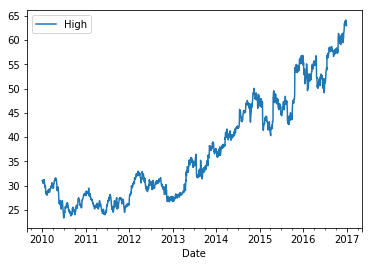

In [47]:
msft.plot(y='High')
pass

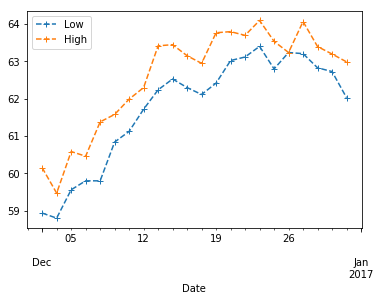

In [48]:
msft.loc['2016-12-01':'2016-12-31', ('Low', 'High')].plot(
    linestyle='dashed', marker='+')
pass

### Indexing

In [49]:
tips[0:2]

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3


In [50]:
tips.loc[0:2]

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


In [51]:
tips.iloc[0:2]

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3


In [52]:
tips.iloc[0:3, [2,3,4]]

,sex,smoker,day
0,Female,No,Sun
1,Male,No,Sun
2,Male,No,Sun


In [53]:
tips.loc[0:2, ['tip', 'sex', 'size']]

,tip,sex,size
0,1.01,Female,2
1,1.66,Male,3
2,3.50,Male,3


In [54]:
tips.loc[0:2, 'tip':'day']

,tip,sex,smoker,day
0,1.01,Female,No,Sun
1,1.66,Male,No,Sun
2,3.50,Male,No,Sun


#### Boolean indexing

In [55]:
tips[tips.sex == 'Male'].head(3)

,total_bill,tip,sex,smoker,day,time,size
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2


In [56]:
tips[(tips.sex == 'Male') & (tips.time != 'Dinner')].head(3)

,total_bill,tip,sex,smoker,day,time,size
77,27.20,4.00,Male,No,Thur,Lunch,4
78,22.76,3.00,Male,No,Thur,Lunch,2
79,17.29,2.71,Male,No,Thur,Lunch,2


### Special selection

In [57]:
df = pd.DataFrame({
    'a': [1,2,None,4,1], 
    'b': [3,3,None,None,3],
    'c': [1,2,None,4,1]})

In [58]:
df

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,NaN,NaN,NaN
3,4.0,NaN,4.0
4,1.0,3.0,1.0


In [59]:
df.dropna()

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
4,1.0,3.0,1.0


In [60]:
df.dropna(how='all')

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
3,4.0,NaN,4.0
4,1.0,3.0,1.0


In [61]:
df.drop_duplicates()

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,NaN,NaN,NaN
3,4.0,NaN,4.0


In [62]:
df.drop_duplicates(keep='last')

,a,b,c
1,2.0,3.0,2.0
2,NaN,NaN,NaN
3,4.0,NaN,4.0
4,1.0,3.0,1.0


### Selecting by label

In [63]:
tips.filter(regex='^s.*').head(3)

,sex,smoker,size
0,Female,No,2
1,Male,No,3
2,Male,No,3


### Sorting

In [64]:
tips.sort_values(['size', 'tip'], ascending=[True, False]).head(3)

,total_bill,tip,sex,smoker,day,time,size
222,8.58,1.92,Male,Yes,Fri,Lunch,1
82,10.07,1.83,Female,No,Thur,Lunch,1
67,3.07,1.00,Female,Yes,Sat,Dinner,1


Note that ordered categorical values are sorted appropriately.

In [65]:
tips.sort_values(['day']).head(3)

,total_bill,tip,sex,smoker,day,time,size
121,13.42,1.68,Female,No,Thur,Lunch,2
133,12.26,2.00,Female,No,Thur,Lunch,2
132,11.17,1.50,Female,No,Thur,Lunch,2


### Rearrange columns

In [66]:
tips = tips[tips.columns.sort_values()]
tips.head(3)

,day,sex,size,smoker,time,tip,total_bill
0,Sun,Female,2,No,Dinner,1.01,16.99
1,Sun,Male,3,No,Dinner,1.66,10.34
2,Sun,Male,3,No,Dinner,3.50,21.01


In [67]:
tips = tips.filter('total_bill	tip	sex	smoker	day	time	size'.split())
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


### Transforms

In [68]:
tips['day_type'] = 'Weekday'
tips.loc[tips.day.isin(['Sat', 'Sun']), 'day_type'] = 'Weekend'
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size,day_type
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend


In [69]:
tips['cost'] = tips['total_bill'] + tips['tip']
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51


In [70]:
tips.assign(log1p_cost = np.log1p(tips.cost)).head(3)

,total_bill,tip,sex,smoker,day,time,size,day_type,cost,log1p_cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00,2.944439
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00,2.564949
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51,3.239071


In [71]:
tips.replace({
    'sex': dict(Femals='F', Male='M'),
    'day': dict(Thur=4, Fri=5, Sat=6, Sun=7)}).head(3)

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,7,Dinner,2,Weekend,18.00
1,10.34,1.66,M,No,7,Dinner,3,Weekend,12.00
2,21.01,3.50,M,No,7,Dinner,3,Weekend,24.51


In [72]:
tips.rename({'sex': 'gender'}, axis=1).head(3)

,total_bill,tip,gender,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51


#### Transforming missing values

In [73]:
df

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,NaN,NaN,NaN
3,4.0,NaN,4.0
4,1.0,3.0,1.0


In [74]:
df.fillna(0)

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,0.0,0.0,0.0
3,4.0,0.0,4.0
4,1.0,3.0,1.0


In [75]:
df.fillna(df.mean())

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,2.0,3.0,2.0
3,4.0,3.0,4.0
4,1.0,3.0,1.0


In [76]:
df.fillna(method='ffill')

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,2.0,3.0,2.0
3,4.0,3.0,4.0
4,1.0,3.0,1.0


In [77]:
df.fillna(method='bfill')

,a,b,c
0,1.0,3.0,1.0
1,2.0,3.0,2.0
2,4.0,3.0,4.0
3,4.0,3.0,4.0
4,1.0,3.0,1.0


### Summaries

In [78]:
tips.mean()

total_bill    19.785943
tip            2.998279
size           2.569672
cost          22.784221
dtype: float64

In [79]:
tips.std()

total_bill    8.902412
tip           1.383638
size          0.951100
cost          9.890116
dtype: float64

In [80]:
tips.count()

total_bill    244
tip           244
sex           244
smoker        244
day           244
time          244
size          244
day_type      244
cost          244
dtype: int64

### Grouping

In [81]:
tips.groupby(['sex', 'day', 'time']).mean()

total_bill       tip      size       cost
sex    day  time                                             
Female Thur Dinner   18.780000  3.000000  2.000000  21.780000
            Lunch    16.648710  2.561935  2.483871  19.210645
       Fri  Dinner   14.310000  2.810000  2.000000  17.120000
            Lunch    13.940000  2.745000  2.250000  16.685000
       Sat  Dinner   19.680357  2.801786  2.250000  22.482143
            Lunch          NaN       NaN       NaN        NaN
       Sun  Dinner   19.872222  3.367222  2.944444  23.239444
            Lunch          NaN       NaN       NaN        NaN
Male   Thur Dinner         NaN       NaN       NaN        NaN
            Lunch    18.714667  2.980333  2.433333  21.695000
       Fri  Dinner   23.487143  3.032857  2.285714  26.520000
            Lunch    11.386667  1.900000  1.666667  13.286667
       Sat  Dinner   20.802542  3.083898  2.644068  23.886441
            Lunch          NaN       NaN       NaN        NaN
       Sun  Dinner   21.887241  3.220345  2.810345  25.107586
            Lunch          NaN       NaN       NaN        NaN

In [82]:
tips.groupby(['sex']).agg(['mean', 'std', 'min', 'max'])

total_bill                              tip                       \
             mean       std   min    max      mean       std  min   max   
sex                                                                       
Female  18.056897  8.009209  3.07  44.30  2.833448  1.159495  1.0   6.5   
Male    20.744076  9.246469  7.25  50.81  3.089618  1.489102  1.0  10.0   

            size                         cost                          
            mean       std min max       mean        std   min    max  
sex                                                                    
Female  2.459770  0.937644   1   6  20.890345   8.841798  4.07  48.11  
Male    2.630573  0.955997   1   6  23.833694  10.303309  9.00  60.81

### Working with hierarchical indexes

In [83]:
df = tips.groupby(['sex', 'day', 'time']).mean()
df.head()

total_bill       tip      size       cost
sex    day  time                                             
Female Thur Dinner   18.780000  3.000000  2.000000  21.780000
            Lunch    16.648710  2.561935  2.483871  19.210645
       Fri  Dinner   14.310000  2.810000  2.000000  17.120000
            Lunch    13.940000  2.745000  2.250000  16.685000
       Sat  Dinner   19.680357  2.801786  2.250000  22.482143

In [84]:
df.index

MultiIndex(levels=[['Female', 'Male'], ['Thur', 'Fri', 'Sat', 'Sun'], ['Dinner', 'Lunch']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 1, 1, 2, 2, 3, 3, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['sex', 'day', 'time'])

In [85]:
df.columns

Index(['total_bill', 'tip', 'size', 'cost'], dtype='object')

In [86]:
df.loc[('Female')]

total_bill       tip      size       cost
day  time                                             
Thur Dinner   18.780000  3.000000  2.000000  21.780000
     Lunch    16.648710  2.561935  2.483871  19.210645
Fri  Dinner   14.310000  2.810000  2.000000  17.120000
     Lunch    13.940000  2.745000  2.250000  16.685000
Sat  Dinner   19.680357  2.801786  2.250000  22.482143
     Lunch          NaN       NaN       NaN        NaN
Sun  Dinner   19.872222  3.367222  2.944444  23.239444
     Lunch          NaN       NaN       NaN        NaN

In [87]:
df.loc[('Female', 'Sat')]

,total_bill,tip,size,cost
time,,,,
Dinner,19.680357,2.801786,2.25,22.482143
Lunch,NaN,NaN,NaN,NaN


In [88]:
df.loc[('Female', slice(None), 'Dinner')]

total_bill       tip      size       cost
sex    day  time                                             
Female Thur Dinner   18.780000  3.000000  2.000000  21.780000
       Fri  Dinner   14.310000  2.810000  2.000000  17.120000
       Sat  Dinner   19.680357  2.801786  2.250000  22.482143
       Sun  Dinner   19.872222  3.367222  2.944444  23.239444

### Stacking and unstacking

In [89]:
tips.head(3)

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51


In [90]:
df.unstack()['tip']

time           Dinner     Lunch
sex    day                     
Female Thur  3.000000  2.561935
       Fri   2.810000  2.745000
       Sat   2.801786       NaN
       Sun   3.367222       NaN
Male   Thur       NaN  2.980333
       Fri   3.032857  1.900000
       Sat   3.083898       NaN
       Sun   3.220345       NaN

In [91]:
df.unstack(level=0)['tip']

sex            Female      Male
day  time                      
Thur Dinner  3.000000       NaN
     Lunch   2.561935  2.980333
Fri  Dinner  2.810000  3.032857
     Lunch   2.745000  1.900000
Sat  Dinner  2.801786  3.083898
     Lunch        NaN       NaN
Sun  Dinner  3.367222  3.220345
     Lunch        NaN       NaN

In [92]:
df.unstack(level=[1,2])['tip']

day      Thur                 Fri              Sat             Sun      
time   Dinner     Lunch    Dinner  Lunch    Dinner Lunch    Dinner Lunch
sex                                                                     
Female    3.0  2.561935  2.810000  2.745  2.801786   NaN  3.367222   NaN
Male      NaN  2.980333  3.032857  1.900  3.083898   NaN  3.220345   NaN

In [93]:
df.unstack(level=[1,2])['tip'].stack(level=0)

time           Dinner     Lunch
sex    day                     
Female Thur  3.000000  2.561935
       Fri   2.810000  2.745000
       Sat   2.801786       NaN
       Sun   3.367222       NaN
Male   Thur       NaN  2.980333
       Fri   3.032857  1.900000
       Sat   3.083898       NaN
       Sun   3.220345       NaN

#### Swapping levels

In [94]:
df.swaplevel(1,2)

total_bill       tip      size       cost
sex    time   day                                            
Female Dinner Thur   18.780000  3.000000  2.000000  21.780000
       Lunch  Thur   16.648710  2.561935  2.483871  19.210645
       Dinner Fri    14.310000  2.810000  2.000000  17.120000
       Lunch  Fri    13.940000  2.745000  2.250000  16.685000
       Dinner Sat    19.680357  2.801786  2.250000  22.482143
       Lunch  Sat          NaN       NaN       NaN        NaN
       Dinner Sun    19.872222  3.367222  2.944444  23.239444
       Lunch  Sun          NaN       NaN       NaN        NaN
Male   Dinner Thur         NaN       NaN       NaN        NaN
       Lunch  Thur   18.714667  2.980333  2.433333  21.695000
       Dinner Fri    23.487143  3.032857  2.285714  26.520000
       Lunch  Fri    11.386667  1.900000  1.666667  13.286667
       Dinner Sat    20.802542  3.083898  2.644068  23.886441
       Lunch  Sat          NaN       NaN       NaN        NaN
       Dinner Sun    21.887241  3.220345  2.810345  25.107586
       Lunch  Sun          NaN       NaN       NaN        NaN

### Resetting index

If you'd rather not deal with hierarchical indexes, use `reset_index`.

In [95]:
df.reset_index()

,sex,day,time,total_bill,tip,size,cost
0,Female,Thur,Dinner,18.780000,3.000000,2.000000,21.780000
1,Female,Thur,Lunch,16.648710,2.561935,2.483871,19.210645
2,Female,Fri,Dinner,14.310000,2.810000,2.000000,17.120000
3,Female,Fri,Lunch,13.940000,2.745000,2.250000,16.685000
4,Female,Sat,Dinner,19.680357,2.801786,2.250000,22.482143
5,Female,Sat,Lunch,NaN,NaN,NaN,NaN
6,Female,Sun,Dinner,19.872222,3.367222,2.944444,23.239444
7,Female,Sun,Lunch,NaN,NaN,NaN,NaN
8,Male,Thur,Dinner,NaN,NaN,NaN,NaN
9,Male,Thur,Lunch,18.714667,2.980333,2.433333,21.695000


### Reshaping

In [96]:
df1 = df.reset_index()

In [97]:
df1.head(3)

,sex,day,time,total_bill,tip,size,cost
0,Female,Thur,Dinner,18.78000,3.000000,2.000000,21.780000
1,Female,Thur,Lunch,16.64871,2.561935,2.483871,19.210645
2,Female,Fri,Dinner,14.31000,2.810000,2.000000,17.120000


#### Transpose

In [98]:
df1.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
sex,Female,Female,Female,Female,Female,Female,Female,Female,Male,Male,Male,Male,Male,Male,Male,Male
day,Thur,Thur,Fri,Fri,Sat,Sat,Sun,Sun,Thur,Thur,Fri,Fri,Sat,Sat,Sun,Sun
time,Dinner,Lunch,Dinner,Lunch,Dinner,Lunch,Dinner,Lunch,Dinner,Lunch,Dinner,Lunch,Dinner,Lunch,Dinner,Lunch
total_bill,18.78,16.6487,14.31,13.94,19.6804,NaN,19.8722,NaN,NaN,18.7147,23.4871,11.3867,20.8025,NaN,21.8872,NaN
tip,3,2.56194,2.81,2.745,2.80179,NaN,3.36722,NaN,NaN,2.98033,3.03286,1.9,3.0839,NaN,3.22034,NaN
size,2,2.48387,2,2.25,2.25,NaN,2.94444,NaN,NaN,2.43333,2.28571,1.66667,2.64407,NaN,2.81034,NaN
cost,21.78,19.2106,17.12,16.685,22.4821,NaN,23.2394,NaN,NaN,21.695,26.52,13.2867,23.8864,NaN,25.1076,NaN


#### Melt (gather)

In [99]:
pd.melt(df1, id_vars=['sex', 'day', 'time', 'size']).head(10)

,sex,day,time,size,variable,value
0,Female,Thur,Dinner,2.000000,total_bill,18.780000
1,Female,Thur,Lunch,2.483871,total_bill,16.648710
2,Female,Fri,Dinner,2.000000,total_bill,14.310000
3,Female,Fri,Lunch,2.250000,total_bill,13.940000
4,Female,Sat,Dinner,2.250000,total_bill,19.680357
5,Female,Sat,Lunch,NaN,total_bill,NaN
6,Female,Sun,Dinner,2.944444,total_bill,19.872222
7,Female,Sun,Lunch,NaN,total_bill,NaN
8,Male,Thur,Dinner,NaN,total_bill,NaN
9,Male,Thur,Lunch,2.433333,total_bill,18.714667


### Pivot table

A pivot table is like a group_by operation on both the index (rows) and columns.

In [100]:
pd.pivot_table(df1, values=['total_bill', 'tip'],
               index=['sex', 'day'], 
               columns='time',
               aggfunc='mean')

tip           total_bill           
time           Dinner     Lunch     Dinner      Lunch
sex    day                                           
Female Thur  3.000000  2.561935  18.780000  16.648710
       Fri   2.810000  2.745000  14.310000  13.940000
       Sat   2.801786       NaN  19.680357        NaN
       Sun   3.367222       NaN  19.872222        NaN
Male   Thur       NaN  2.980333        NaN  18.714667
       Fri   3.032857  1.900000  23.487143  11.386667
       Sat   3.083898       NaN  20.802542        NaN
       Sun   3.220345       NaN  21.887241        NaN

### Joining data frames

In [101]:
tips1 = tips[0:5]
tips1

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20


In [102]:
tips2 = tips[3:8]
tips2

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20
5,25.29,4.71,Male,No,Sun,Dinner,4,Weekend,30.00
6,8.77,2.00,Male,No,Sun,Dinner,2,Weekend,10.77
7,26.88,3.12,Male,No,Sun,Dinner,4,Weekend,30.00


#### Simple concatenation

In [103]:
pd.concat([tips1, tips2])

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20
5,25.29,4.71,Male,No,Sun,Dinner,4,Weekend,30.00
6,8.77,2.00,Male,No,Sun,Dinner,2,Weekend,10.77
7,26.88,3.12,Male,No,Sun,Dinner,4,Weekend,30.00


### Joining columns

Merge uses all common columns to combine. It is very flexible - see help(pd.merge).

In [104]:
pd.merge(tips1, tips2)

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
1,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20


In [105]:
pd.merge(tips1, tips2, how='left')

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20


In [106]:
pd.merge(tips1, tips2, how='right')

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
1,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20
2,25.29,4.71,Male,No,Sun,Dinner,4,Weekend,30.00
3,8.77,2.00,Male,No,Sun,Dinner,2,Weekend,10.77
4,26.88,3.12,Male,No,Sun,Dinner,4,Weekend,30.00


In [107]:
pd.merge(tips1, tips2, how='outer')

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20
5,25.29,4.71,Male,No,Sun,Dinner,4,Weekend,30.00
6,8.77,2.00,Male,No,Sun,Dinner,2,Weekend,10.77
7,26.88,3.12,Male,No,Sun,Dinner,4,Weekend,30.00


## Visualizing data

In [108]:
tips.head()

,total_bill,tip,sex,smoker,day,time,size,day_type,cost
0,16.99,1.01,Female,No,Sun,Dinner,2,Weekend,18.00
1,10.34,1.66,Male,No,Sun,Dinner,3,Weekend,12.00
2,21.01,3.50,Male,No,Sun,Dinner,3,Weekend,24.51
3,23.68,3.31,Male,No,Sun,Dinner,2,Weekend,26.99
4,24.59,3.61,Female,No,Sun,Dinner,4,Weekend,28.20


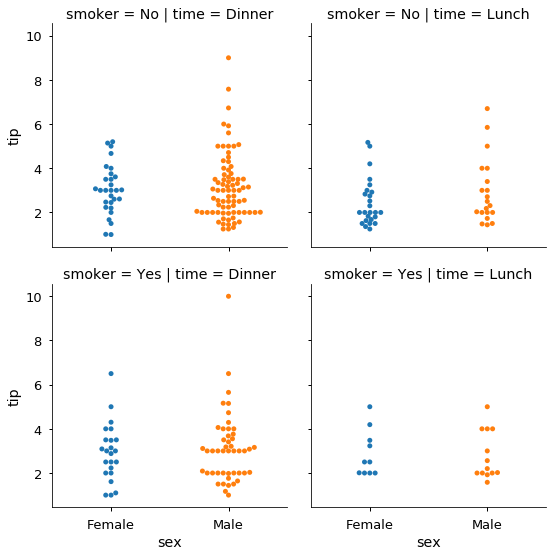

In [109]:
sns.set_context('notebook', font_scale=1.3)
g = sns.factorplot(x='sex', y='tip',
                   col='time', row='smoker',
                   data=tips, kind='swarm')
pass

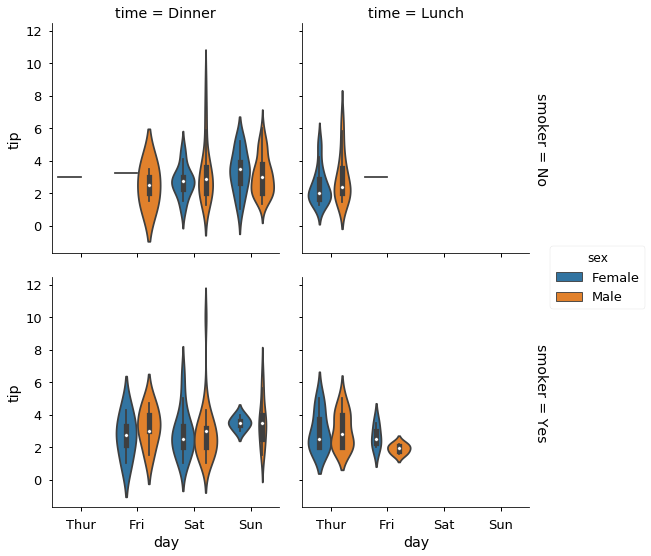

In [110]:
sns.set_context('notebook', font_scale=1.3)
g = sns.factorplot(x='day', y='tip', hue='sex',
                   col='time', row='smoker',
                   data=tips, kind='violin', 
                   margin_titles=True)
pass

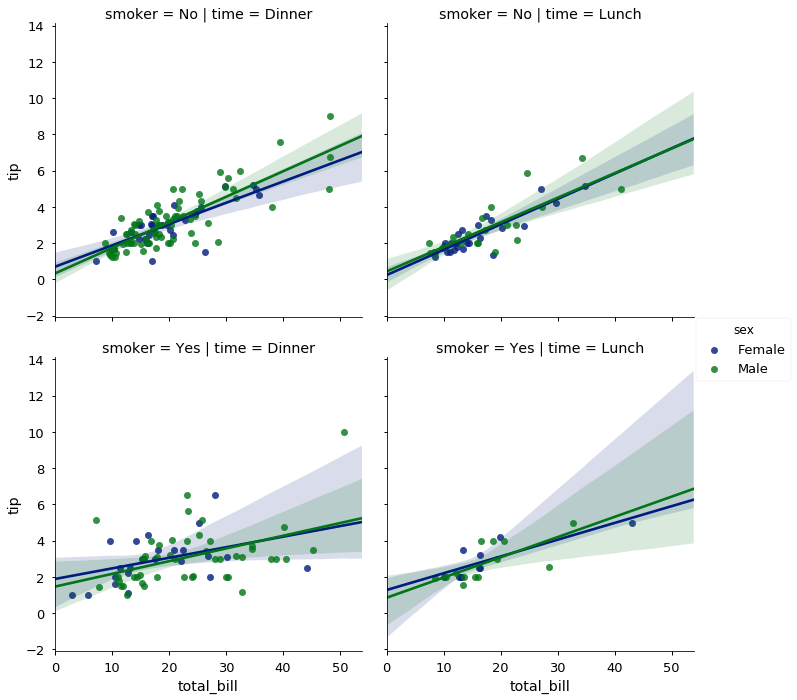

In [111]:
sns.lmplot(x='total_bill', y='tip', hue='sex', 
           col='time', row='smoker', 
           data=tips, palette='dark')
pass